# Chess Auto Encoder

- Use HalfKP

TODO:
- Fetch fens
- Convert to HalfKP
- Save to file

In [25]:
# refresh imports
%load_ext autoreload
%autoreload 2

import torch
import pandas as pd
import chess
from tqdm import tqdm
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from utils import   get_FenBatchProvider, transform
from stockfish_explain.gen_concepts import create_custom_concepts

# set default plot size as large
plt.rcParams['figure.figsize'] = [20, 10]



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create Dataset

## Fetch fens 

In [4]:
batch_size = 50
num_batch = 1000

FBP = get_FenBatchProvider(batch_size=batch_size)

def fetch_batch():
    fens = next(FBP)
    results = []
    for i, fen in enumerate(fens):
        d = {}
        d['fen'] = fen
        board = chess.Board(fen)
        pieces = dict(Counter([str(v) for v in board.piece_map().values()]))
        d = {**d, **pieces}

        results.append(d)
    return results


data = []
for i in tqdm(range(num_batch)):
    data = data  + fetch_batch()
print(f'Len data: {len(data)}')

df = pd.DataFrame(data).fillna(0)
del data
print(f'df shape: {df.shape}')

100%|██████████| 1000/1000 [00:03<00:00, 283.22it/s]


Len data: 50000
df shape: (50000, 13)


## Add concepts

In [4]:
print(df.shape)
# add concept_dict to df
for idx, row in tqdm(df.iterrows()):
    board = chess.Board(row['fen'])
    concept_dict = create_custom_concepts(board)
    for k, v in concept_dict.items():
        df.at[idx, k] = v   
print(df.shape)

columns_names = {
    'K': 'white_king',
    'k': 'black_king',
    'Q': 'white_queen',
    'q': 'black_queen',
    'R': 'white_rook',
    'r': 'black_rook',
    'B': 'white_bishop',
    'b': 'black_bishop',
    'N': 'white_knight',
    'n': 'black_knight',
    'P': 'white_pawn',
    'p': 'black_pawn',
}


df = df.rename(columns=columns_names)

(50000, 13)


50000it [01:41, 492.51it/s]

(50000, 29)


In [5]:
columns_names = {
    'K': 'white_king',
    'k': 'black_king',
    'Q': 'white_queen',
    'q': 'black_queen',
    'R': 'white_rook',
    'r': 'black_rook',
    'B': 'white_bishop',
    'b': 'black_bishop',
    'N': 'white_knight',
    'n': 'black_knight',
    'P': 'white_pawn',
    'p': 'black_pawn',
}


df = df.rename(columns=columns_names)

In [6]:
# store df in sqlite db for later use
import sqlite3
conn = sqlite3.connect('chess_auto_encoder.db')
df.to_sql('fen_concept_df', conn, if_exists='replace', index=True)
conn.close()

del df


## Convert to HalfKP

# Dataset

# Autoencoder


# Custom Autoencoder

In [36]:
import matplotlib.pyplot as plt
from model import DeepAutoencoder
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

batch_size = 200
train_loader = get_FenBatchProvider(batch_size=batch_size)
val_loader = get_FenBatchProvider(batch_size=batch_size)


# Instantiating the model and hyperparameters
model = DeepAutoencoder(input_size=641)
criterion = torch.nn.MSELoss()
#criterion = torch.nn.CrossEntropyLoss()
num_epochs = 1000
max_iterations = 500
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model = model.cuda()

# List that will store the training loss
train_loss = []
  
# Dictionary that will store the
# different images and outputs for 
# various epochs
outputs = {}
  
  
# Training loop starts
for epoch in tqdm(range(num_epochs)):
        
    # Initializing variable for storing 
    # loss
    running_loss = 0
      
    it = 0
    # Iterating over the training dataset
    for batch in train_loader:

        if it == max_iterations:
            break
        it += 1
            
        # Loading image(s) and
        # reshaping it into a 1-d vector
        img = batch
        img = transform(img) 
        img = img.reshape(-1, model.input_size).cuda()
          
        # Generating output
        out = model(img)
          
        # Calculating loss
        loss = criterion(out, img)
          
        # Updating weights according
        # to the calculated loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
          
        # Incrementing loss
        running_loss += loss.item()
      
    # Averaging out loss over entire batch
    running_loss /= batch_size
    train_loss.append(running_loss)

    writer.add_scalar("Loss/train", running_loss, epoch)
      
    # Storing useful images and
    # reconstructed outputs for the last batch
    outputs[epoch+1] = {'img': img, 'out': out}
  
  
writer.flush()
# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

# save model to disk
torch.save(model.state_dict(), 'model.pt')


  0%|          | 2/1000 [00:33<4:41:21, 16.91s/it]

# Fetch activations from encoders

In [30]:
from scipy.sparse import csr_matrix, vstack
from tqdm import tqdm
import pandas as pd
import sqlite3
from model import DeepAutoencoder

# load model from disk

model = DeepAutoencoder(input_size = 641)
model.load_state_dict(torch.load('model.pt'))

# load df from sqlite db
conn = sqlite3.connect('chess_auto_encoder.db')
df = pd.read_sql_query('select * from fen_concept_df', conn)
conn.close()

activation = {}
def get_output_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_input_activation(name):
    def hook(model, input, output):
        activation['input_'+name] = input[0].detach()
    return hook

model.encoder_0.register_forward_hook(get_input_activation('encoder_0'))
model.encoder_0.register_forward_hook(get_output_activation('encoder_0'))
model.encoder_1.register_forward_hook(get_output_activation('encoder_1'))
model.encoder_2.register_forward_hook(get_output_activation('encoder_2'))
model.encoder_3.register_forward_hook(get_output_activation('encoder_3'))
model.decoder_0.register_forward_hook(get_output_activation('decoder_0'))
model.decoder_1.register_forward_hook(get_output_activation('decoder_1'))
model.decoder_2.register_forward_hook(get_output_activation('decoder_2'))
model.decoder_3.register_forward_hook(get_output_activation('decoder_3'))

model.cuda()

activation_list = []

for idx, row in tqdm(df.iterrows()):

    data = transform([row['fen']]).cuda()
    output = model(data)

    activations_ = {'index': idx}
    for k, v in activation.items():
        values = v.cpu().numpy()[0]
        if 0:
            if k in ['input_encoder_0',]:
                # convert values to csr matrix with boolean values
                values = csr_matrix(values, dtype=bool)
            elif k in ['decoder_3']:
                # convert values to csr matrix with boolean values
                values = csr_matrix(values > 0, dtype=bool)
            else:
                # convert values to numpy float16
                values = values.astype(np.float16)
        values = values.astype(np.float16)
        
        activations_[k] = values


    # copy activation and add to activation_list
    activation_list.append(activations_.copy())

df_activations = pd.DataFrame(activation_list)

50000it [00:39, 1262.13it/s]


In [17]:
df_activations.head()

,index,input_encoder_0,encoder_0,encoder_1,encoder_2,encoder_3,decoder_0,decoder_1,decoder_2,decoder_3
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.1578, 0.0475, 0.0889, 0.02658, 0.03934, 0.0...","[1.624, 1.138, 1.288, 1.411, 1.261, -0.1667, 1...","[-0.63, 0.7773, 1.055, 1.538, -0.3022, -0.729,...","[0.1543, -2.6, 0.1808, -0.2346, 1.025, 0.4998,...","[0.3916, 1.063, 1.781, 0.64, -0.6997, 0.765, 1...","[0.411, 1.007, 0.819, 0.2461, -0.0818, -0.0182...","[0.4387, 0.3782, 0.4934, 0.2426, 0.11554, -0.1...","[-4.215, -4.066, -4.13, -4.28, -4.12, -4.23, -..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0911, 0.11255, 0.07745, 0.02144, -0.0649, -...","[1.106, 0.81, 0.932, 0.99, 0.8857, -0.0938, 1....","[-0.4402, 0.517, 0.75, 1.046, -0.2108, -0.5234...","[0.1654, -1.8545, 0.1688, -0.21, 0.764, 0.392,...","[0.2666, 0.7886, 1.223, 0.4907, -0.537, 0.514,...","[0.2778, 0.7837, 0.571, 0.2588, -0.0634, -0.00...","[0.3176, 0.2295, 0.3784, 0.1887, 0.11926, -0.1...","[-3.234, -3.09, -3.156, -3.273, -3.156, -3.26,..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3394, 0.2013, 0.287, 0.2795, 0.348, 0.3298,...","[4.652, 3.418, 3.824, 3.79, 3.86, -0.294, 4.27...","[-1.662, 2.416, 2.92, 4.773, -1.056, -2.055, 4...","[0.04144, -7.402, 0.2153, -0.3098, 2.791, 1.19...","[1.184, 2.852, 5.383, 1.6045, -1.737, 2.398, 3...","[1.275, 2.46, 2.377, 0.1236, -0.2255, -0.0661,...","[1.231, 1.358, 1.24, 0.596, 0.10754, -0.1114, ...","[-10.6, -10.42, -10.46, -10.836, -10.41, -10.5..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.03592, 0.03262, 0.0168, 0.0814, 0.0811, 0.0...","[1.108, 0.7974, 0.9414, 1.02, 0.9033, -0.12067...","[-0.4458, 0.5264, 0.7676, 1.018, -0.2177, -0.5...","[0.1659, -1.86, 0.1772, -0.2228, 0.76, 0.3875,...","[0.2668, 0.7886, 1.223, 0.4937, -0.537, 0.51, ...","[0.278, 0.7827, 0.571, 0.257, -0.0647, -0.0095...","[0.3171, 0.23, 0.3784, 0.1887, 0.119, -0.1112,...","[-3.236, -3.092, -3.158, -3.273, -3.156, -3.26..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3535, 0.2903, 0.395, 0.3655, 0.4543, 0.4817...","[6.043, 4.336, 4.8, 4.66, 4.934, -0.4246, 5.45...","[-2.143, 3.152, 3.598, 6.207, -1.416, -2.531, ...","[-0.02019, -9.484, 0.2177, -0.2935, 3.56, 1.47...","[1.517, 3.61, 6.91, 2.0, -2.174, 3.08, 4.684, ...","[1.632, 3.076, 3.041, 0.06384, -0.278, -0.0934...","[1.569, 1.78, 1.555, 0.7485, 0.10223, -0.1096,...","[-13.31, -13.13, -13.16, -13.62, -13.08, -13.2..."


In [18]:
idx = 0
input = df_activations.iloc[idx]['input_encoder_0']
output = df_activations.iloc[idx]['decoder_3']

print(input)

print(output)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [21]:
from scipy.special import expit

expit(output).min()

0.010052369

In [5]:
df_activations['decoder_3']

0         
1         
2         
3         
4         
        ..
49995     
49996     
49997     
49998     
49999     
Name: decoder_3, Length: 50000, dtype: object

In [4]:
df.columns.tolist()

['index',
 'fen',
 'black_rook',
 'black_king',
 'white_pawn',
 'white_rook',
 'black_pawn',
 'white_king',
 'black_queen',
 'black_knight',
 'black_bishop',
 'white_queen',
 'white_knight',
 'white_bishop',
 'white_bishop_pair',
 'black_bishop_pair',
 'white_knight_pair',
 'black_knight_pair',
 'white_double_pawn',
 'black_double_pawn',
 'white_isolated_pawns',
 'black_isolated_pawns',
 'white_connected_rooks',
 'black_connected_rooks',
 'white_has_control_of_open_file',
 'black_has_control_of_open_file',
 'has_contested_open_file',
 'is_forking',
 'can_fork',
 'can_check']

# Concept Model

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (
    ElasticNet,
    LogisticRegression,
    Ridge,
    RidgeClassifier,
    SGDRegressor,
    LinearRegression,
)
from lightgbm import LGBMClassifier, LGBMRegressor

from imblearn.under_sampling import RandomUnderSampler
# import confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


def classification_cost(y_test, y_pred):
    y_test = np.array(y_test).astype(int)
    y_pred = np.array(y_pred).astype(int)
    residuals = 1 - np.abs(y_pred - y_test)
    return np.mean(residuals) * 2 - 1

test_size = 0.33
input_name = 'encoder_3'
target_name = 'has_contested_open_file'

concept_model = LGBMClassifier()
#concept_model = LogisticRegression()
metric = classification_cost

verbose = False

undersample = RandomUnderSampler(
    sampling_strategy="majority"
)

concept_models = [RidgeClassifier(), LGBMClassifier(), LogisticRegression()]
input_names = ['input_encoder_0', 'encoder_0', 'encoder_1', 'encoder_2', 'encoder_3', 'decoder_0', 'decoder_1', 'decoder_2','decoder_3']
target_names = ['has_contested_open_file','white_double_pawn', 'white_queen']


results = []
for concept_model in concept_models:
    for input_name in input_names:
        for target_name in target_names:

            model_name = f"{concept_model.__class__.__name__}"

            X = df_activations[input_name].tolist()
            y = df[target_name].tolist()
            print(f"X: {input_name}, y: {target_name}, model_name: .{model_name}")

            # if X is scipy.sparse.csr_matrix, vstack it 
            if isinstance(X[0], csr_matrix):
                X = vstack(X).astype(np.float32)
                size = X.shape[1]
            else:
                size = len(X[0])

            # change type of y to int
            y = np.array(y).astype(int)

            if target_name == 'white_queen':
                # is y larger than 0
                y = y > 0

            # fit and apply the transform
            X, y = undersample.fit_resample(X, y)


            # split into train and test sets 
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=42, stratify=y
            )



            concept_model.fit(X_train, list(y_train))
            y_pred = concept_model.predict(X_test)

            score = metric(y_test, y_pred)

            # calculate confusion matrix
            matrix = confusion_matrix(y_test, y_pred)

            if verbose:
                print(f'Target value counts: {pd.Series(y_train).value_counts()}')
                print(f'Target value counts: {pd.Series(y_test).value_counts()}')
                print(f'input shape: {size}')
                print(matrix)
                print(score)

            results_ = {'model_name': model_name,
                        'input_name': input_name, 
                        'target_name': target_name,
                        'score': score, 
                        'size': size}
            results.append(results_)

df_results = pd.DataFrame(results)
df_results

X: input_encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: input_encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: input_encoder_0, y: white_queen, model_name: .RidgeClassifier
X: encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_0, y: white_queen, model_name: .RidgeClassifier
X: encoder_1, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_1, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_1, y: white_queen, model_name: .RidgeClassifier
X: encoder_2, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_2, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_2, y: white_queen, model_name: .RidgeClassifier
X: encoder_3, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_3, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_3, y: white_queen, model_name: .RidgeClassifier
X: deco

/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


X: input_encoder_0, y: white_queen, model_name: .LogisticRegression
X: encoder_0, y: has_contested_open_file, model_name: .LogisticRegression


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


X: encoder_0, y: white_double_pawn, model_name: .LogisticRegression


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


X: encoder_0, y: white_queen, model_name: .LogisticRegression


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


X: encoder_1, y: has_contested_open_file, model_name: .LogisticRegression


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


X: encoder_1, y: white_double_pawn, model_name: .LogisticRegression


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


X: encoder_1, y: white_queen, model_name: .LogisticRegression


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


X: encoder_2, y: has_contested_open_file, model_name: .LogisticRegression
X: encoder_2, y: white_double_pawn, model_name: .LogisticRegression


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

X: encoder_2, y: white_queen, model_name: .LogisticRegression


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


X: encoder_3, y: has_contested_open_file, model_name: .LogisticRegression
X: encoder_3, y: white_double_pawn, model_name: .LogisticRegression
X: encoder_3, y: white_queen, model_name: .LogisticRegression
X: decoder_0, y: has_contested_open_file, model_name: .LogisticRegression
X: decoder_0, y: white_double_pawn, model_name: .LogisticRegression
X: decoder_0, y: white_queen, model_name: .LogisticRegression
X: decoder_1, y: has_contested_open_file, model_name: .LogisticRegression
X: decoder_1, y: white_double_pawn, model_name: .LogisticRegression


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

X: decoder_1, y: white_queen, model_name: .LogisticRegression


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


X: decoder_2, y: has_contested_open_file, model_name: .LogisticRegression


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


X: decoder_2, y: white_double_pawn, model_name: .LogisticRegression


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


X: decoder_2, y: white_queen, model_name: .LogisticRegression


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


X: decoder_3, y: has_contested_open_file, model_name: .LogisticRegression


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


X: decoder_3, y: white_double_pawn, model_name: .LogisticRegression


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


X: decoder_3, y: white_queen, model_name: .LogisticRegression


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model_name,input_name,target_name,score,size
0,RidgeClassifier,input_encoder_0,has_contested_open_file,0.486636,641
1,RidgeClassifier,input_encoder_0,white_double_pawn,0.496329,641
2,RidgeClassifier,input_encoder_0,white_queen,1.000000,641
3,RidgeClassifier,encoder_0,has_contested_open_file,0.492688,1024
4,RidgeClassifier,encoder_0,white_double_pawn,0.485450,1024
...,...,...,...,...,...
76,LogisticRegression,decoder_2,white_double_pawn,0.280392,1024
77,LogisticRegression,decoder_2,white_queen,0.625765,1024
78,LogisticRegression,decoder_3,has_contested_open_file,0.410993,641
79,LogisticRegression,decoder_3,white_double_pawn,0.336959,641


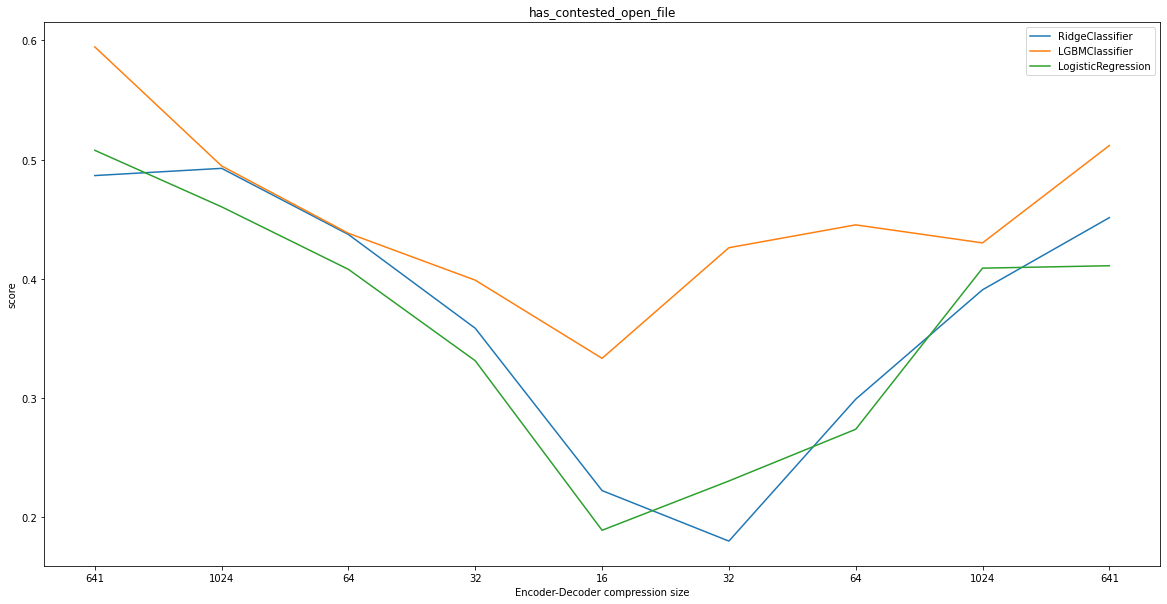

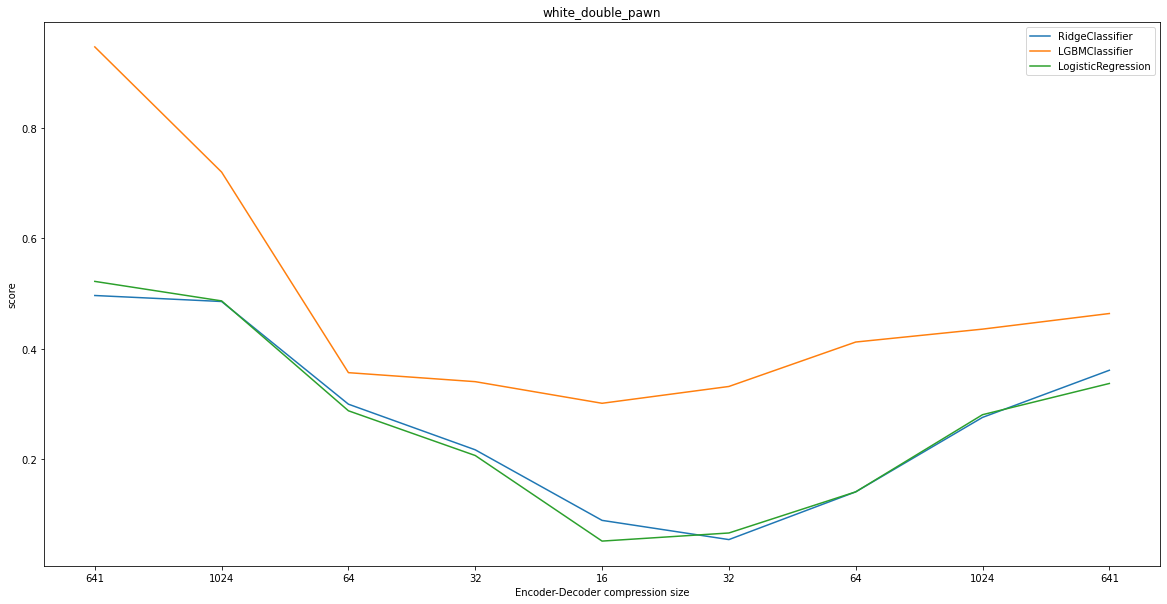

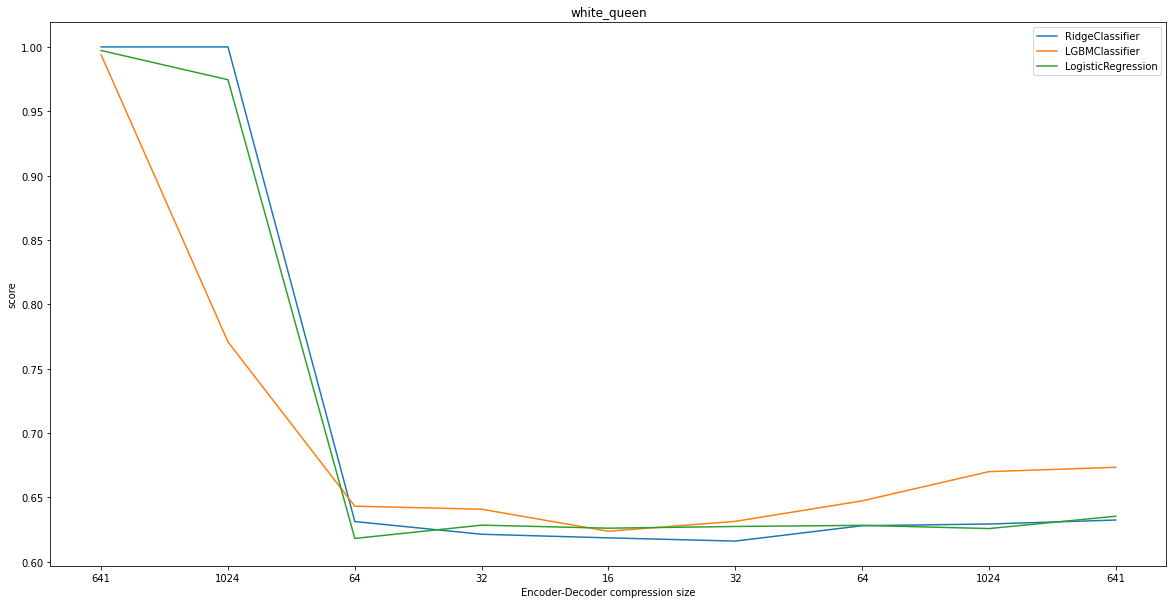

In [32]:
for target_name in df_results.target_name.unique():
    df_results_ = df_results[df_results.target_name == target_name]
    for model_name  in df_results_.model_name.unique():
        # plot scores
        plt.plot(range(len(df_results_[df_results_.model_name == model_name])), df_results_[df_results_.model_name == model_name].score, label=model_name)

    # set x ticks as size   
    plt.xticks(range(len(df_results_[df_results_.model_name == model_name])), df_results_[df_results_.model_name == model_name]['size'].astype(str))
    plt.title(target_name)
    plt.ylabel('score')
    plt.xlabel('Encoder-Decoder compression size')
    plt.legend()
    plt.show()

# 

In [9]:
torch.sigmoid(torch.tensor(00))

tensor(0.5000)